In [1]:
from diffusers.utils import load_image
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch
from diffusers import UniPCMultistepScheduler

/home/ubuntu/anaconda3/envs/dreambooth/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Canny

(512, 512)


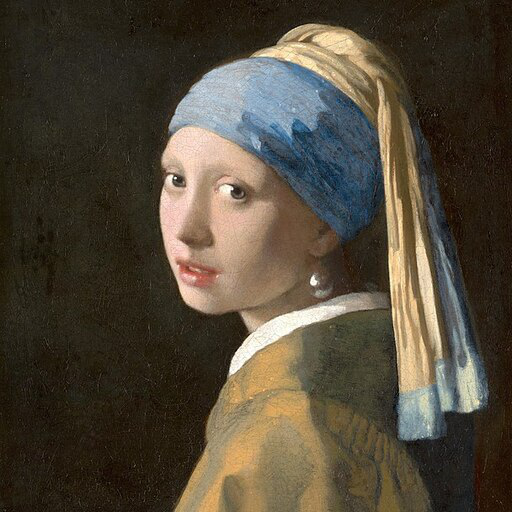

In [2]:
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
print(image.size)
image

In [14]:
# !which python
# !ls /usr/bin/python*

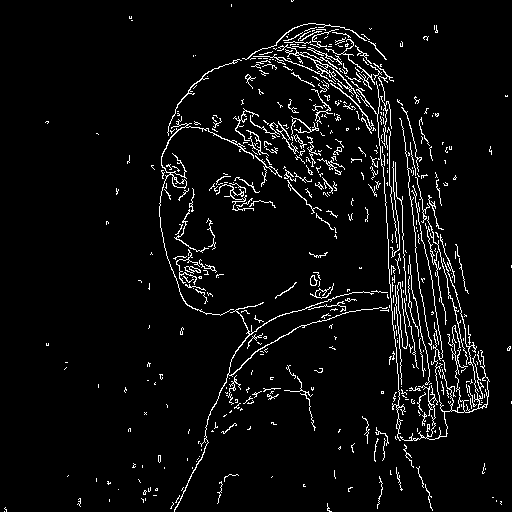

In [15]:
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [16]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.enable_model_cpu_offload() # move model to gpu smartly

Fetching 15 files: 100%|████████████| 15/15 [00:00<00:00, 108100.62it/s]


In [17]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


In [7]:
prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Sandra Oh", "Kim Kardashian", "rihanna", "taylor swift"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

In [8]:
prompt

['Sandra Oh, best quality, extremely detailed',
 'Kim Kardashian, best quality, extremely detailed',
 'rihanna, best quality, extremely detailed',
 'taylor swift, best quality, extremely detailed']

100%|███████████████████████████████████| 20/20 [00:03<00:00,  5.41it/s]


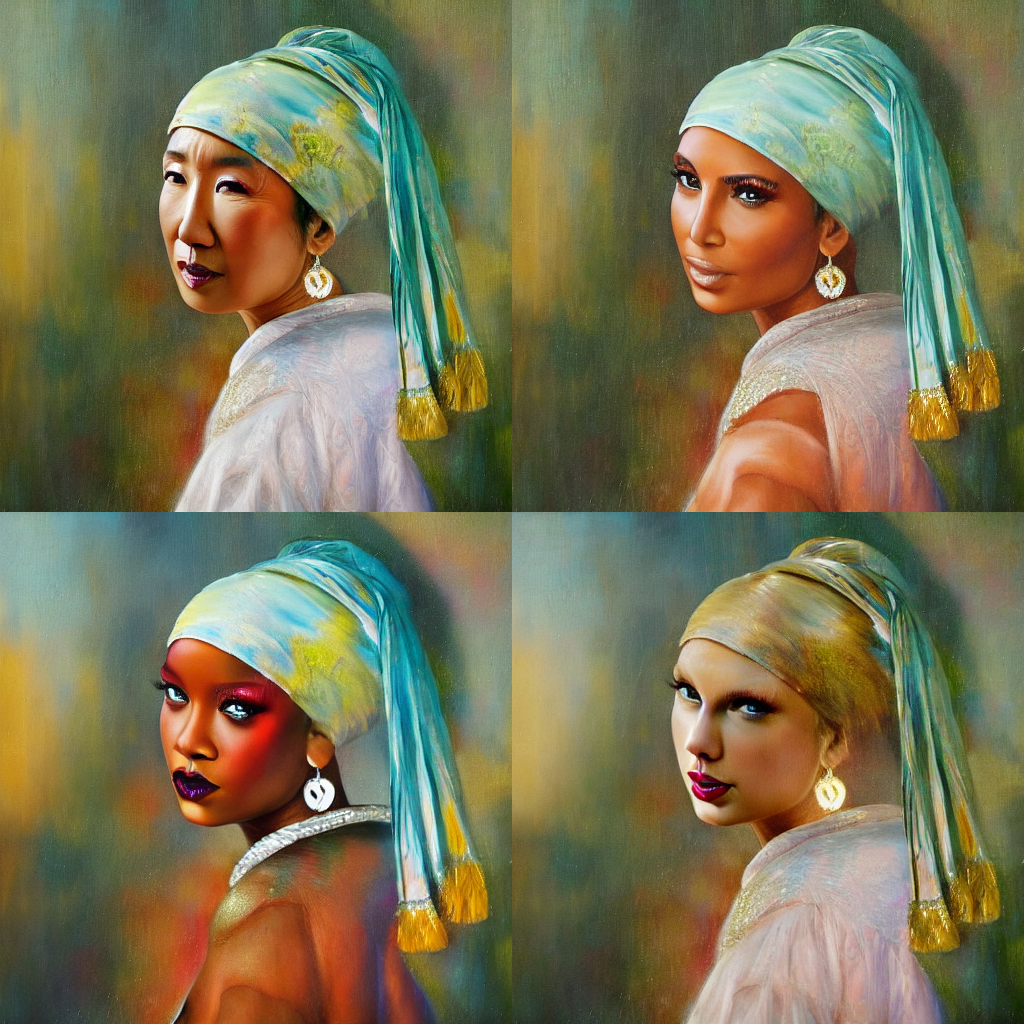

In [9]:
output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=20,
    generator=generator,
)

image_grid(output.images, 2, 2)

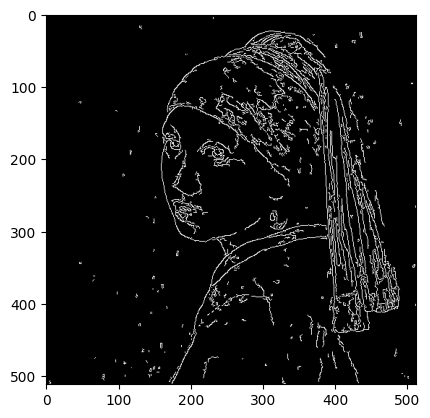

Fetching 15 files: 100%|████████████| 15/15 [00:00<00:00, 109226.67it/s]


NameError: name 'UniPCMultistepScheduler' is not defined

In [10]:
# 简化版本
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch
from diffusers.utils import load_image

image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image = np.array(image)
# get canny image
low_threshold = 100
high_threshold = 200
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
plt.imshow(canny_image)
plt.show()

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()

generator = torch.manual_seed(0)
image = pipe(
    "disco dancer with colorful lights", num_inference_steps=20, generator=generator, image=canny_image
).images[0]

image
# image.save("generated.png")

# Openpose

In [ ]:
urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
imgs = [
    load_image("https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url) 
    for url in urls
]

image_grid(imgs, 2, 2)

In [ ]:
# !pip install opencv-contrib-python
# !pip install controlnet_aux

In [ ]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

In [ ]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()


In [ ]:
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]
prompt = "super-hero character, best quality, extremely detailed"
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    generator=generator,
    num_inference_steps=20,
)
image_grid(output.images, 2, 2)

# Inpainting with controlnet
https://github.com/haofanwang/ControlNet-for-Diffusers

In [ ]:
control_inpaint = "ControlNet-for-Diffusers/pipeline_stable_diffusion_controlnet_inpaint.py"
control_img2img = "ControlNet-for-Diffusers/pipeline_stable_diffusion_controlnet_inpaint_img2img.py"
exec(open(control_inpaint).read())
exec(open(control_img2img).read())

In [ ]:
from diffusers.schedulers import KarrasDiffusionSchedulers
from diffusers.utils import is_accelerate_available, logging, randn_tensor, replace_example_docstring
from diffusers import DiffusionPipeline
from diffusers import StableDiffusionPipelineOutput

In [ ]:
import diffusers
import torch
import os
import subprocess
import torch
from diffusers.utils import load_image

In [ ]:
print(os.path.abspath(diffusers.__file__))
subprocess.run(["pwd"])
# subprocess.run(["git", "clone", "https://github.com/haofanwang/ControlNet-for-Diffusers"])
# cp pipeline_stable_diffusion_controlnet_inpaint.py /home/ubuntu/anaconda3/envs/dreambooth/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion

In [ ]:
# PATH = "/home/ubuntu/anaconda3/envs/dreambooth/lib/python3.10/site-packages/diffusers"
# cd /home/ubuntu/anaconda3/envs/dreambooth/lib/python3.10/site-packages/diffusers/pipelines/__init__.py
# cd /home/ubuntu/anaconda3/envs/dreambooth/lib/python3.10/site-packages/diffusers/__init__.py

In [ ]:
# we have downloaded models locally, you can also load from huggingface
# control_sd15_seg is converted from control_sd15_seg.safetensors using instructions above
pipe_control = StableDiffusionControlNetInpaintPipeline.from_pretrained("./diffusers/control_sd15_seg",torch_dtype=torch.float16).to('cuda')
pipe_inpaint = StableDiffusionInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-2-inpainting",torch_dtype=torch.float16).to('cuda')

# yes, we can directly replace the UNet
pipe_control.unet = pipe_inpaint.unet
pipe_control.unet.in_channels = 4

# we also the same example as stable-diffusion-inpainting
image = load_image("https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png")
mask = load_image("https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png")

# the segmentation result is generated from https://huggingface.co/spaces/hysts/ControlNet
control_image = load_image('tmptvkkr0tg.png')

image = pipe_control(prompt="Face of a yellow cat, high resolution, sitting on a park bench", 
                     negative_prompt="lowres, bad anatomy, worst quality, low quality",
                     controlnet_hint=control_image, 
                     image=image,
                     mask_image=mask,
                     num_inference_steps=100).images[0]

image.save("inpaint_seg.jpg")

In [ ]:
pipe_control = StableDiffusionControlNetInpaintPipeline.from_pretrained("lllyasviel/sd-controlnet-seg",torch_dtype=torch.float16).to('cuda')('cuda')

In [ ]:
from diffusers import StableDiffusionInpaintPipeline, StableDiffusionControlNetInpaintPipeline


In [ ]:
from diffusers.utils import load_image
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Canny

In [ ]:
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image

In [ ]:
# !which python
# !ls /usr/bin/python*

In [ ]:
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.enable_model_cpu_offload() # move model to gpu smartly

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


In [ ]:
prompt = ", best quality, extremely detailed"
prompt = [t + prompt for t in ["Sandra Oh", "Kim Kardashian", "rihanna", "taylor swift"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

In [ ]:
prompt

In [ ]:
output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    num_inference_steps=20,
    generator=generator,
)

image_grid(output.images, 2, 2)

In [ ]:
# 简化版本
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch
from diffusers.utils import load_image

image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image = np.array(image)
# get canny image
low_threshold = 100
high_threshold = 200
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
plt.imshow(canny_image)
plt.show()

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()

generator = torch.manual_seed(0)
image = pipe(
    "disco dancer with colorful lights", num_inference_steps=20, generator=generator, image=canny_image
).images[0]

image
# image.save("generated.png")

# Openpose

In [ ]:
urls = "yoga1.jpeg", "yoga2.jpeg", "yoga3.jpeg", "yoga4.jpeg"
imgs = [
    load_image("https://huggingface.co/datasets/YiYiXu/controlnet-testing/resolve/main/" + url) 
    for url in urls
]

image_grid(imgs, 2, 2)

In [ ]:
# !pip install opencv-contrib-python
# !pip install controlnet_aux

In [ ]:
from controlnet_aux import OpenposeDetector

model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

poses = [model(img) for img in imgs]
image_grid(poses, 2, 2)

In [ ]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()


In [ ]:
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(4)]
prompt = "super-hero character, best quality, extremely detailed"
output = pipe(
    [prompt] * 4,
    poses,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * 4,
    generator=generator,
    num_inference_steps=20,
)
image_grid(output.images, 2, 2)

# Inpainting with controlnet
https://github.com/haofanwang/ControlNet-for-Diffusers

In [ ]:
from diffusers import StableDiffusionControlNetInpaintPipeline

In [ ]:
import numpy as np
import torch
from PIL import Image
from stable_diffusion_controlnet_inpaint import StableDiffusionControlNetInpaintPipeline
from transformers import AutoImageProcessor, UperNetForSemanticSegmentation
from diffusers import ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image

# HED edge

In [ ]:
from pytorch_lightning import seed_everything
import os
import torch
from einops import rearrange

In [ ]:
class HEDdetector:
    def __init__(self):
        remote_model_path = "https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/network-bsds500.pth"
        modelpath = os.path.join("./", "network-bsds500.pth")
        if not os.path.exists(modelpath):
            from basicsr.utils.download_util import load_file_from_url
            load_file_from_url(remote_model_path, model_dir="./")
        self.netNetwork = Network(modelpath).cuda().eval()

    def __call__(self, input_image):
        assert input_image.ndim == 3
        input_image = input_image[:, :, ::-1].copy()
        with torch.no_grad():
            image_hed = torch.from_numpy(input_image).float().cuda()
            image_hed = image_hed / 255.0
            image_hed = rearrange(image_hed, 'h w c -> 1 c h w')
            edge = self.netNetwork(image_hed)[0]
            edge = (edge.cpu().numpy() * 255.0).clip(0, 255).astype(np.uint8)
            return edge[0]

In [ ]:
class Network(torch.nn.Module):
    def __init__(self, model_path):
        super().__init__()

        self.netVggOne = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netVggTwo = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netVggThr = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netVggFou = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netVggFiv = torch.nn.Sequential(
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=False)
        )

        self.netScoreOne = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.netScoreTwo = torch.nn.Conv2d(in_channels=128, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.netScoreThr = torch.nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.netScoreFou = torch.nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0)
        self.netScoreFiv = torch.nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1, padding=0)

        self.netCombine = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=5, out_channels=1, kernel_size=1, stride=1, padding=0),
            torch.nn.Sigmoid()
        )

        self.load_state_dict({strKey.replace('module', 'net'): tenWeight for strKey, tenWeight in torch.load(model_path).items()})

    def forward(self, tenInput):
        tenInput = tenInput * 255.0
        tenInput = tenInput - torch.tensor(data=[104.00698793, 116.66876762, 122.67891434], dtype=tenInput.dtype, device=tenInput.device).view(1, 3, 1, 1)

        tenVggOne = self.netVggOne(tenInput)
        tenVggTwo = self.netVggTwo(tenVggOne)
        tenVggThr = self.netVggThr(tenVggTwo)
        tenVggFou = self.netVggFou(tenVggThr)
        tenVggFiv = self.netVggFiv(tenVggFou)

        tenScoreOne = self.netScoreOne(tenVggOne)
        tenScoreTwo = self.netScoreTwo(tenVggTwo)
        tenScoreThr = self.netScoreThr(tenVggThr)
        tenScoreFou = self.netScoreFou(tenVggFou)
        tenScoreFiv = self.netScoreFiv(tenVggFiv)

        tenScoreOne = torch.nn.functional.interpolate(input=tenScoreOne, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)
        tenScoreTwo = torch.nn.functional.interpolate(input=tenScoreTwo, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)
        tenScoreThr = torch.nn.functional.interpolate(input=tenScoreThr, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)
        tenScoreFou = torch.nn.functional.interpolate(input=tenScoreFou, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)
        tenScoreFiv = torch.nn.functional.interpolate(input=tenScoreFiv, size=(tenInput.shape[2], tenInput.shape[3]), mode='bilinear', align_corners=False)

        return self.netCombine(torch.cat([ tenScoreOne, tenScoreTwo, tenScoreThr, tenScoreFou, tenScoreFiv ], 1))

def resize_image(input_image, resolution):
    H, W, C = input_image.shape
    H = float(H)
    W = float(W)
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(np.round(H / 64.0)) * 64
    W = int(np.round(W / 64.0)) * 64
    img = cv2.resize(input_image, (W, H), interpolation=cv2.INTER_LANCZOS4 if k > 1 else cv2.INTER_AREA)
    return img

In [ ]:
def HWC3(x):
    assert x.dtype == np.uint8
    if x.ndim == 2:
        x = x[:, :, None]
    assert x.ndim == 3
    H, W, C = x.shape
    assert C == 1 or C == 3 or C == 4
    if C == 3:
        return x
    if C == 1:
        return np.concatenate([x, x, x], axis=2)
    if C == 4:
        color = x[:, :, 0:3].astype(np.float32)
        alpha = x[:, :, 3:4].astype(np.float32) / 255.0
        y = color * alpha + 255.0 * (1.0 - alpha)
        y = y.clip(0, 255).astype(np.uint8)
        return y

In [ ]:
apply_hed = HEDdetector()

In [ ]:
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
image

In [ ]:
image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image
print(np.unique(canny_image))

In [ ]:
image = np.array(image)
detected_map = apply_hed(resize_image(image, 512))
detected_map = HWC3(detected_map)
img = resize_image(image, 512)
H, W, C = img.shape
plt.imshow(img)
print(np.unique(img))
print(np.shape(img))
print(np.allclose(img[:,:,0],img[:,:,1]),np.allclose(img[:,:,1],img[:,:,2]))

In [11]:
lora_model_path = "/home/ubuntu/diffusers/JiaranDianaLoraASOUL_v20SingleCostume.safetensors"
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)
pipe.unet.load_attn_procs(lora_model_path)
# speed up diffusion process with faster scheduler and memory optimization
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload()

Fetching 15 files: 100%|█████████████| 15/15 [00:00<00:00, 55091.56it/s]


UnpicklingError: invalid load key, '\x1b'.

In [3]:
hed_image = Image.open("/home/ubuntu/AI二次元/0319_jia_ran/input_frames/image_0001.png")

In [4]:
hed_image.size

(512, 512)

In [6]:
prompt = ", best quality, extremely detailed"

In [9]:
generator = torch.Generator(device="cpu").manual_seed(2)
prompt = "animation girl, best quality, extremely detailed"
output = pipe(
    prompt,
    hed_image,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
    generator=generator,
    num_inference_steps=20,
)
output

100%|███████████████████████████████████| 20/20 [00:01<00:00, 12.74it/s]


StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7FCBA0CCFAF0>], nsfw_content_detected=[False])

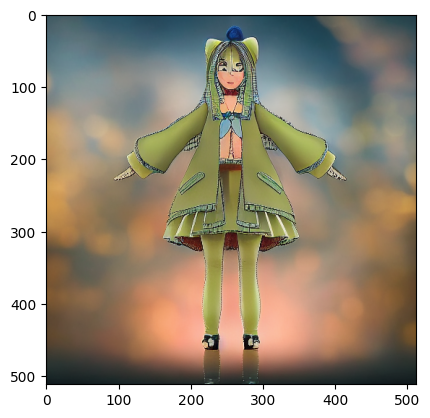

In [10]:
plt.imshow(output[0][0])